I compared the sentiment scores of the JoeBiden and realDonaldTrump
twitter feeds. It seems that if anything, Biden is more neutral whereas Trump
falls into negative or positive polarisation more often. Trump seems to be
especially more positive in the upper quartile of the pos distribution.

In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import biokit.viz as bviz
import heatmap
import matplotlib
import matplotlib.pyplot as plt
from src.data.reader import TwitterReader, CSSEReader
from src.utils.statistics import correlation_matrix
sns.set(style='ticks', context='notebook')

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (12, 6)

Biden

In [185]:
reader = TwitterReader(dirname='twitter_user')
d = reader.read_sentiments()
biden = d['JoeBiden']

# smooth
window = "3d"
win_type = None
biden_mean = biden.rolling(window=window, center=False, win_type=win_type).mean()
biden_sd = biden.rolling(window=window, center=False, win_type=win_type).std()

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x13da6d890>,
      dtype=object)

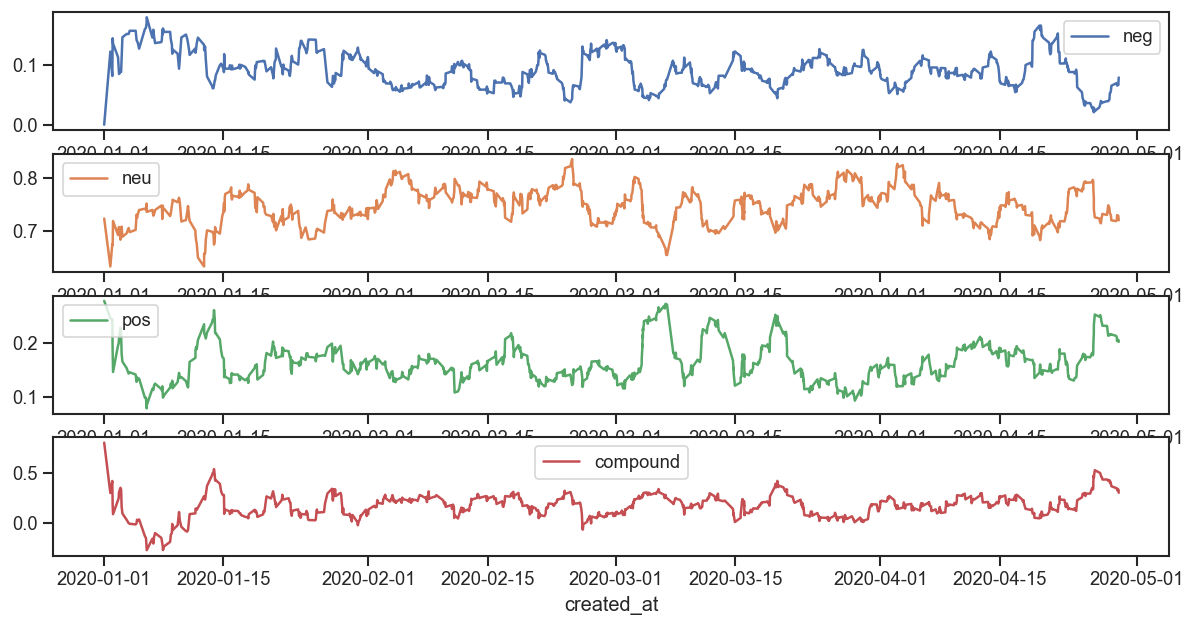

In [186]:
# plot
fig, ax = plt.subplots(figsize=(12,6))
#biden.plot(yerr=biden_sd, capsize=4,capthick=1, subplots=True, ax=ax)
biden_mean.plot(subplots=True, ax=ax)

Trump

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x145a48950>,
      dtype=object)

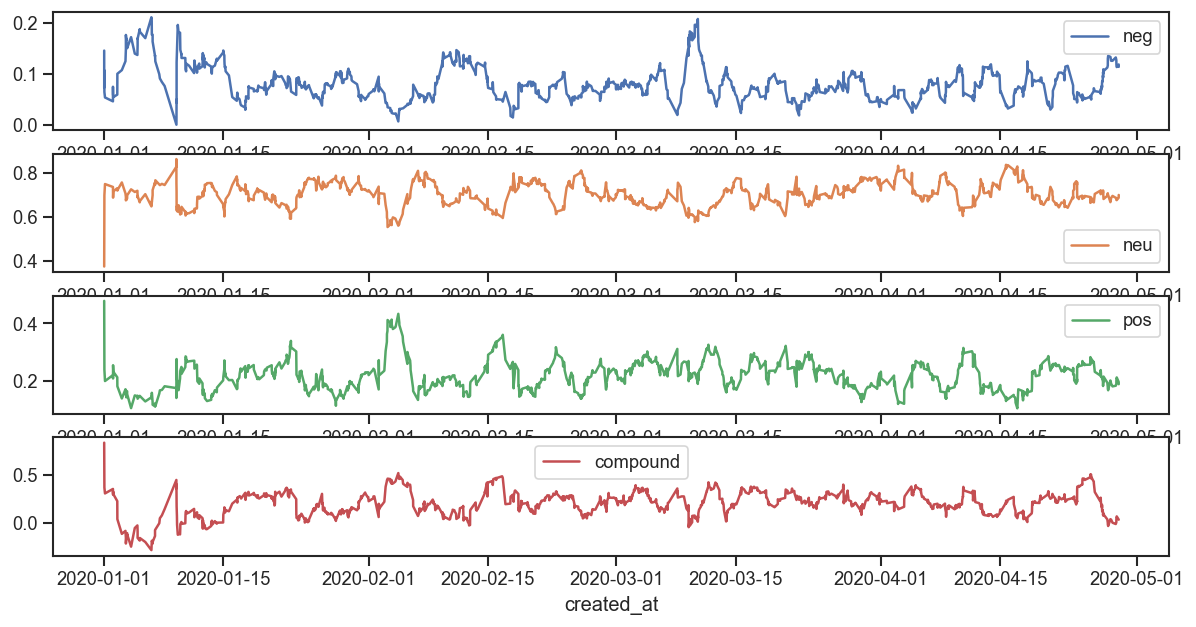

In [187]:
reader = TwitterReader(dirname='twitter_user')
d = reader.read_sentiments()
trump = d['realDonaldTrump']

# smooth
window = "2d"
trump_mean = trump.rolling(window=window, center=False).mean()
trump_sd = trump.rolling(window=window, center=False).std()

# plot
fig, ax = plt.subplots(figsize=(12,6))
#biden.plot(yerr=biden_sd, capsize=4,capthick=1, subplots=True, ax=ax)
trump_mean.plot(subplots=True, ax=ax)

Violinplots of sentiment score distribution

Text(0.5, 1.0, 'JoeBiden')

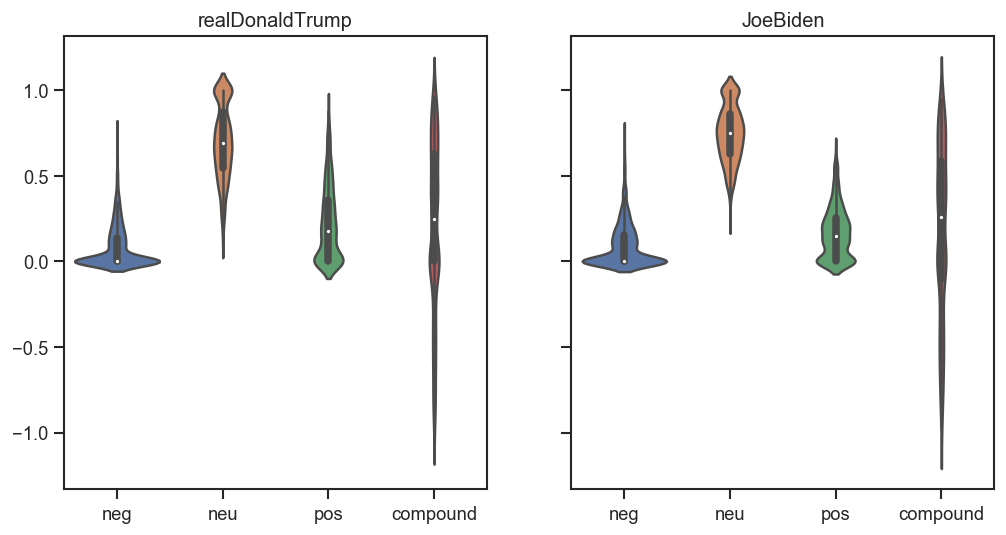

In [188]:
f, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

sns.violinplot(data=trump, ax=axes[0])
axes[0].set_title("realDonaldTrump")

sns.violinplot(data=biden, ax=axes[1])
axes[1].set_title("JoeBiden")

In [189]:
print("Trump\n", trump.describe())
print("\nBiden\n", biden.describe())

Trump
                neg          neu          pos     compound
count  1521.000000  1521.000000  1521.000000  1521.000000
mean      0.080657     0.701133     0.218211     0.198887
std       0.124450     0.214283     0.216630     0.491720
min       0.000000     0.120000     0.000000    -0.957100
25%       0.000000     0.545000     0.000000     0.000000
50%       0.000000     0.694000     0.176000     0.250000
75%       0.139000     0.874000     0.361000     0.624900
max       0.765000     1.000000     0.880000     0.964300

Biden
                neg          neu          pos     compound
count  1052.000000  1052.000000  1052.000000  1052.000000
mean      0.088340     0.746804     0.164858     0.179285
std       0.120985     0.161908     0.148596     0.492022
min       0.000000     0.244000     0.000000    -0.965700
25%       0.000000     0.629000     0.000000    -0.102700
50%       0.000000     0.749500     0.147000     0.256050
75%       0.154000     0.861250     0.254250     0.585900

Read JHU CSSE data

In [190]:
csse = CSSEReader('csse')
csse_data = csse.read_processed_nc()
csse_us = csse_data.sum(dim='county')

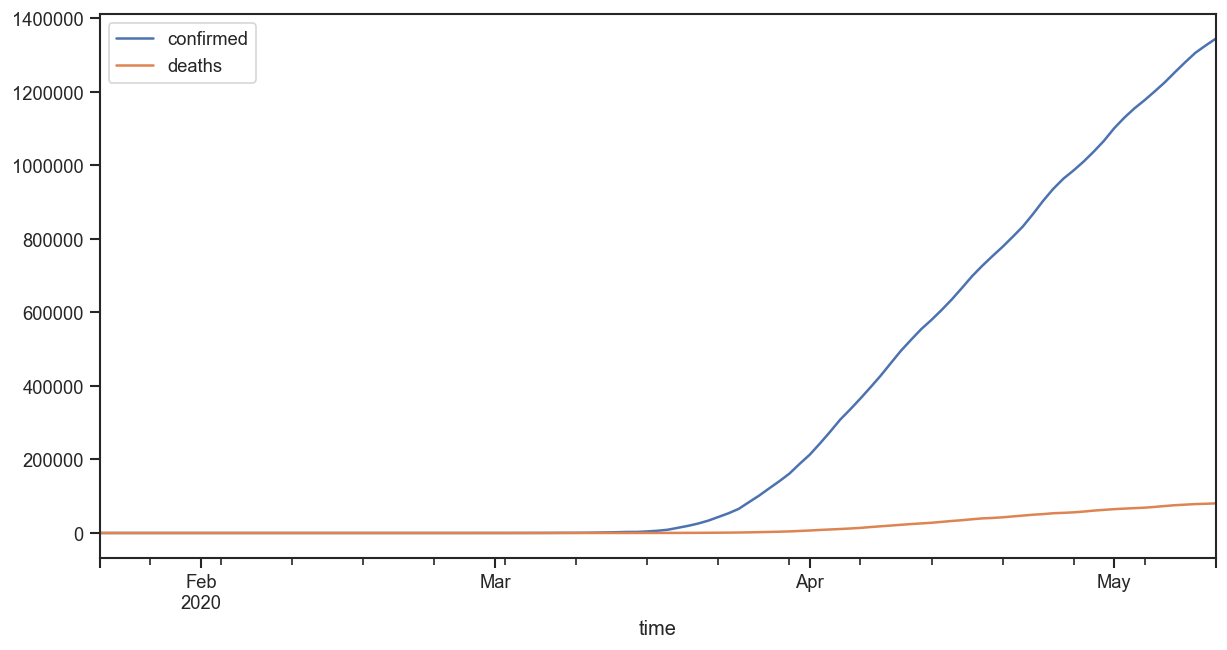

In [191]:
df_csse = csse_us.to_dataframe()
df_csse.plot(subplots=False)

Calculate derivatives of deaths and infections

In [192]:
df_csse['confirmed_d1'] = np.gradient(df_csse['confirmed'].values)
df_csse['deaths_d1'] = np.gradient(df_csse['deaths'].values)

df_csse['confirmed_d2'] = np.gradient(df_csse['confirmed_d1'].values)
df_csse['deaths_d2'] = np.gradient(df_csse['deaths_d1'].values)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x149063cd0>,
      dtype=object)

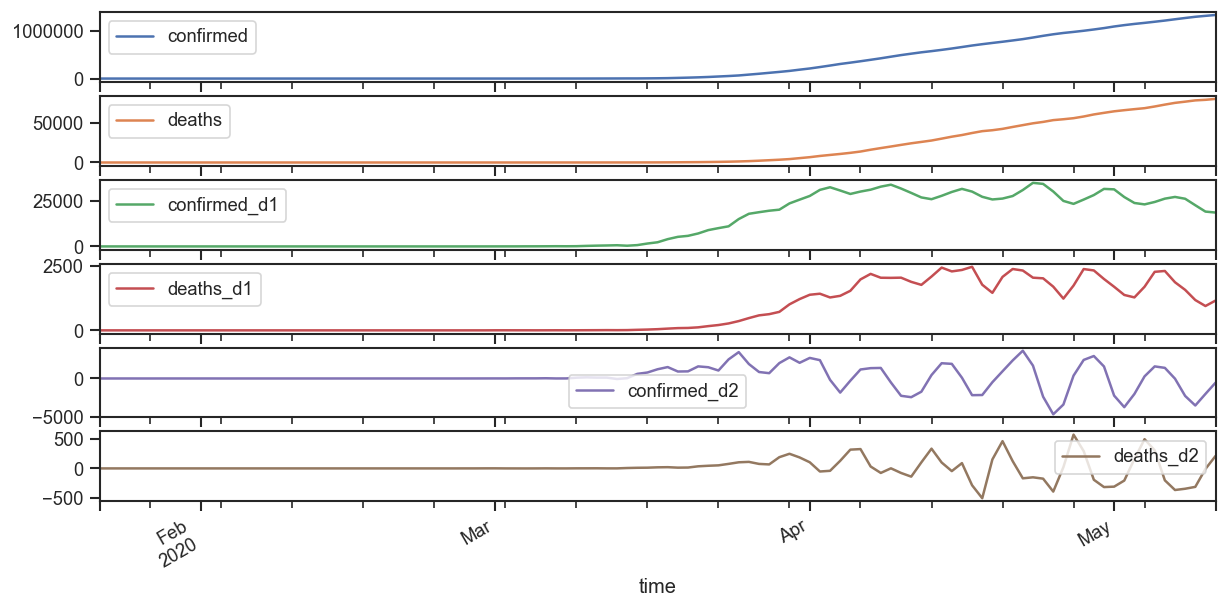

In [193]:
df_csse.plot(subplots=True, figsize=(12,6))

Smoothing experiments

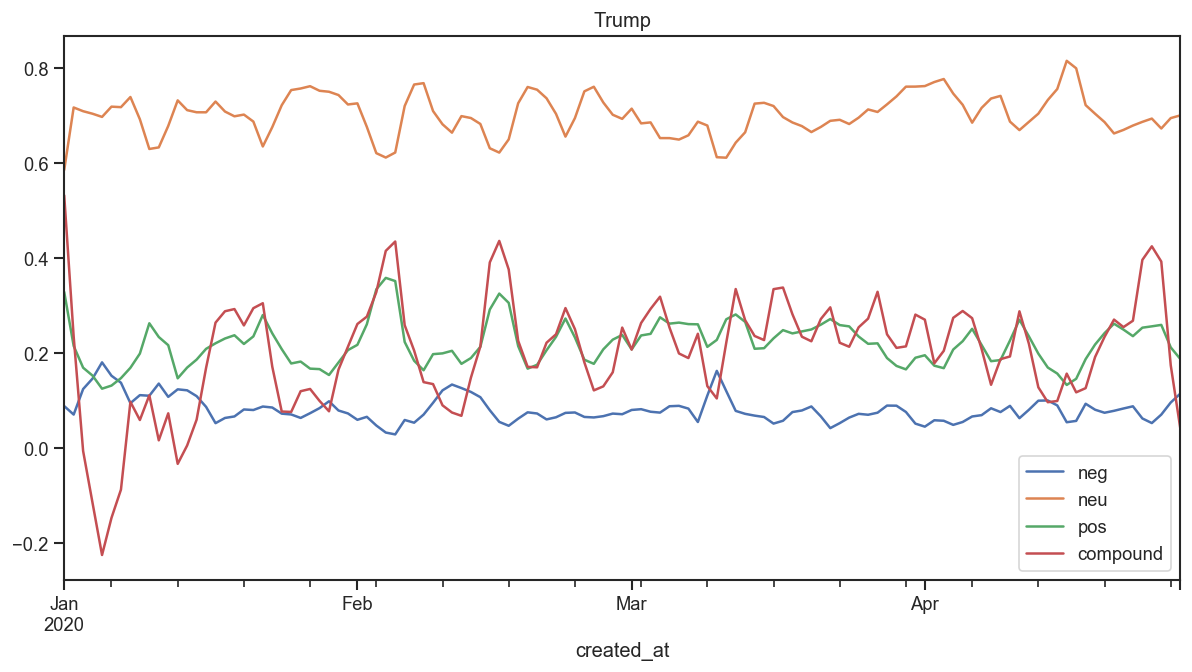

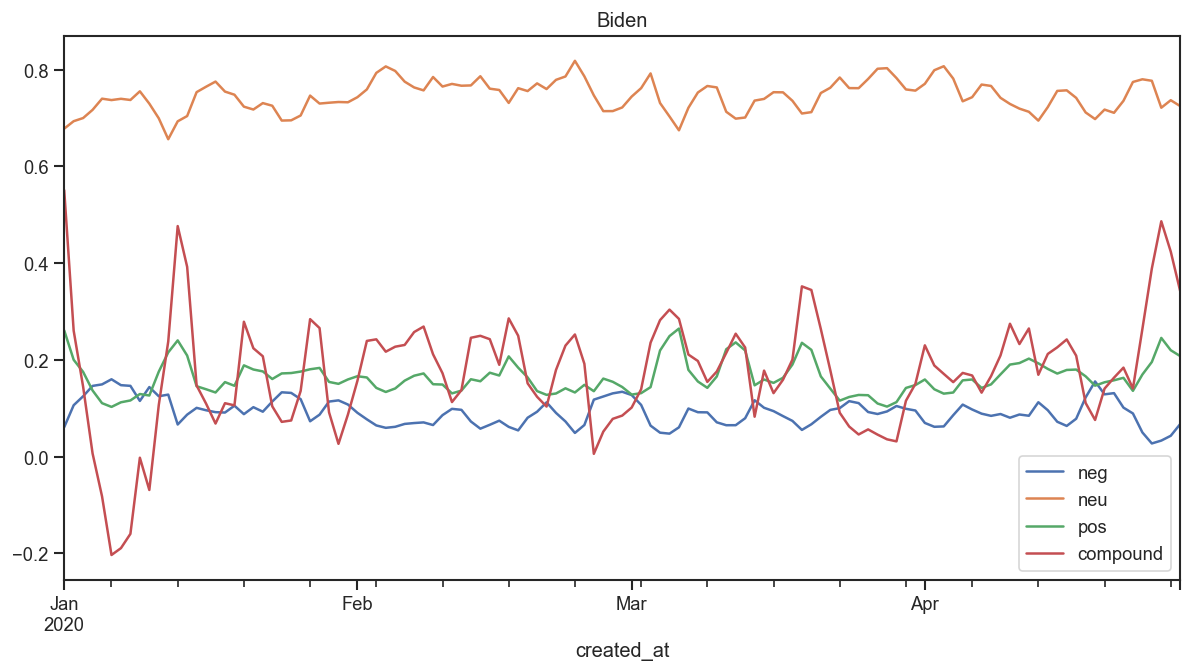

In [194]:
window = "3d"

# trump
trump_mean = trump.rolling(window=window, center=False).mean()
trump_daily = trump_mean.resample('D').mean()
trump_daily.plot(figsize=(12,6), title='Trump')

# biden
biden_mean = biden.rolling(window=window, center=False).mean()
biden_daily = biden_mean.resample('D').mean()
biden_daily.plot(figsize=(12,6), title='Biden')

Merge CSSE and twitter data

In [195]:
#df_csse['tstamps'] = df_csse.index
#trump_daily['tstamps'] = trump_daily.index
#biden_daily['tstamps'] = biden_daily.index

# name indices
trump_daily.index.name = 'time'
biden_daily.index.name = 'time'
df_csse.index.name = 'time'

# remove timezone information
trump_daily.index = trump_daily.index.tz_localize(None)
biden_daily.index = biden_daily.index.tz_localize(None)


In [196]:
csse_trump_merged = pd.merge(trump_daily, df_csse, how='outer', left_index=True, right_index=True)
csse_biden_merged = pd.merge(biden_daily, df_csse, how='outer', left_index=True, right_index=True)

Correlation analysis

In [197]:
# Trump
corr_trump, pvals_trump = correlation_matrix(csse_trump_merged)

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/biokit/viz/corrplot.py:402: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=False)


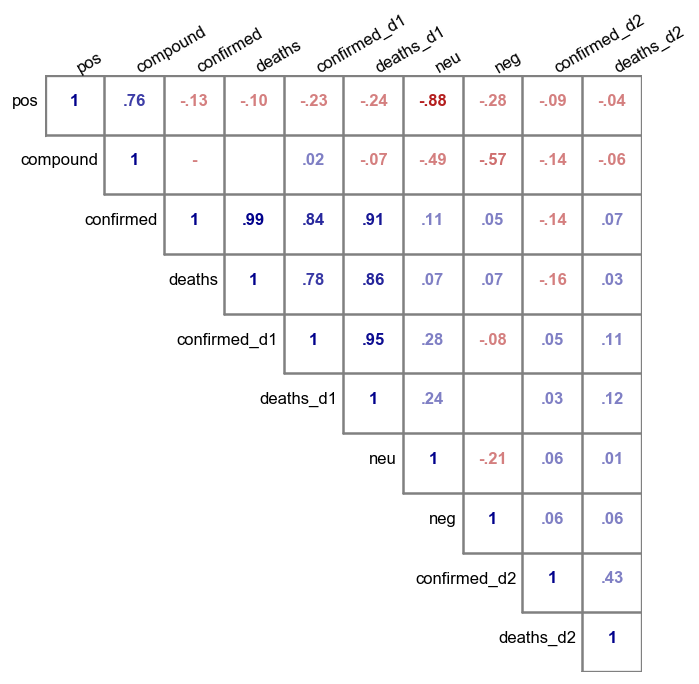

In [198]:
# using biokit
c_trump = bviz.corrplot.Corrplot(corr_trump)
c_trump.plot(colorbar=False, method='text', upper='text', shrink=.9)

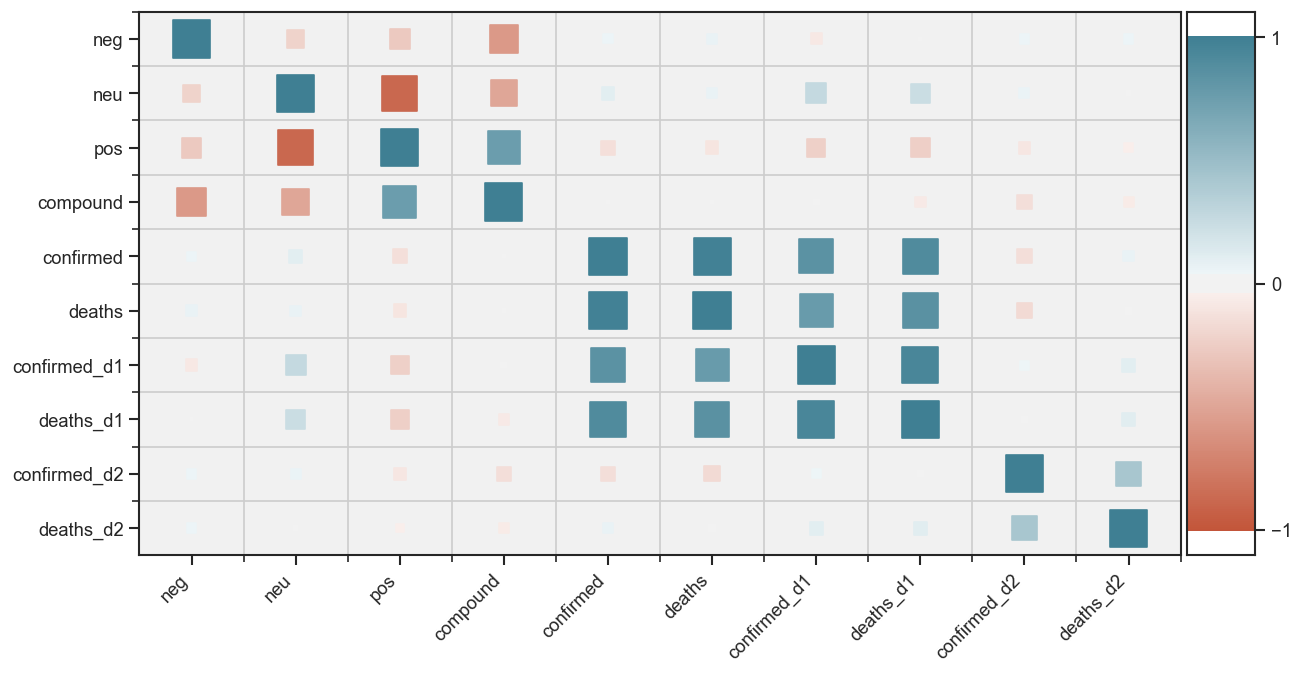

In [199]:
# using heatmapz
heatmap.corrplot(corr_trump)

In [200]:
pvals_trump.style.background_gradient(cmap='Greens_r')

,neg,neu,pos,compound,confirmed,deaths,confirmed_d1,deaths_d1,confirmed_d2,deaths_d2
neg,0.000000,0.037100,0.005700,0.000000,0.617400,0.480100,0.427100,0.991700,0.572300,0.584700
neu,0.037100,0.000000,0.000000,0.000000,0.284000,0.503200,0.006100,0.016800,0.530400,0.895600
pos,0.005700,0.000000,0.000000,0.000000,0.195000,0.317300,0.022100,0.018700,0.373100,0.694300
compound,0.000000,0.000000,0.000000,0.000000,0.998400,0.965400,0.815900,0.474000,0.173400,0.534600
confirmed,0.617400,0.284000,0.195000,0.998400,0.000000,0.000000,0.000000,0.000000,0.176200,0.511700
deaths,0.480100,0.503200,0.317300,0.965400,0.000000,0.000000,0.000000,0.000000,0.113800,0.735400
confirmed_d1,0.427100,0.006100,0.022100,0.815900,0.000000,0.000000,0.000000,0.000000,0.636200,0.276600
deaths_d1,0.991700,0.016800,0.018700,0.474000,0.000000,0.000000,0.000000,0.000000,0.787200,0.257200
confirmed_d2,0.572300,0.530400,0.373100,0.173400,0.176200,0.113800,0.636200,0.787200,0.000000,0.000000
deaths_d2,0.584700,0.895600,0.694300,0.534600,0.511700,0.735400,0.276600,0.257200,0.000000,0.000000


In [201]:
# Biden
corr_biden, pvals_biden = correlation_matrix(csse_biden_merged)

/Users/felix/miniconda3/envs/bd4pp/lib/python3.7/site-packages/biokit/viz/corrplot.py:402: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
  withdash=False)


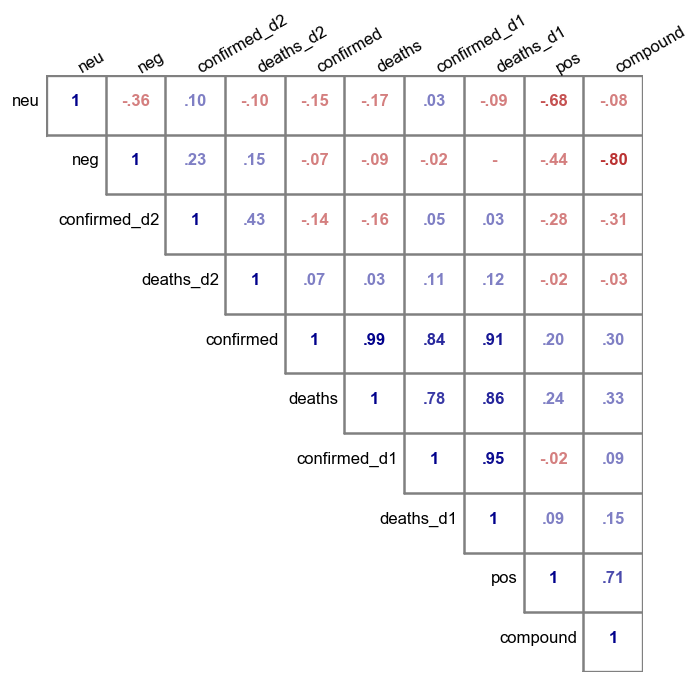

In [202]:
c_biden = bviz.corrplot.Corrplot(corr_biden)
c_biden.plot(colorbar=False, method='text', upper='text', shrink=.9)

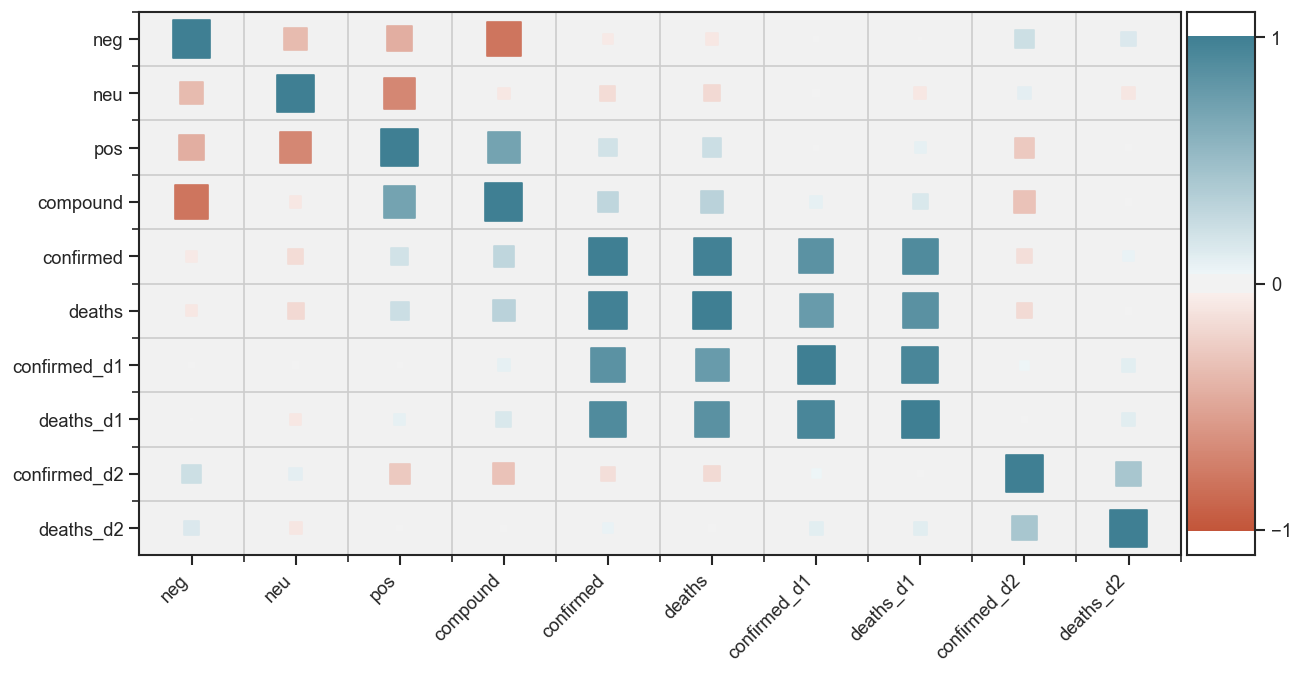

In [203]:
heatmap.corrplot(corr_biden)

In [204]:
pvals_biden.style.background_gradient(cmap='Greens_r')


,neg,neu,pos,compound,confirmed,deaths,confirmed_d1,deaths_d1,confirmed_d2,deaths_d2
neg,0.000000,0.000300,0.000000,0.000000,0.479600,0.394300,0.853200,0.999300,0.022300,0.151500
neu,0.000300,0.000000,0.000000,0.412800,0.129200,0.086400,0.745200,0.379500,0.328300,0.345200
pos,0.000000,0.000000,0.000000,0.000000,0.043100,0.019600,0.865300,0.398500,0.005800,0.832100
compound,0.000000,0.412800,0.000000,0.000000,0.003000,0.001000,0.405600,0.131800,0.001700,0.784700
confirmed,0.479600,0.129200,0.043100,0.003000,0.000000,0.000000,0.000000,0.000000,0.176200,0.511700
deaths,0.394300,0.086400,0.019600,0.001000,0.000000,0.000000,0.000000,0.000000,0.113800,0.735400
confirmed_d1,0.853200,0.745200,0.865300,0.405600,0.000000,0.000000,0.000000,0.000000,0.636200,0.276600
deaths_d1,0.999300,0.379500,0.398500,0.131800,0.000000,0.000000,0.000000,0.000000,0.787200,0.257200
confirmed_d2,0.022300,0.328300,0.005800,0.001700,0.176200,0.113800,0.636200,0.787200,0.000000,0.000000
deaths_d2,0.151500,0.345200,0.832100,0.784700,0.511700,0.735400,0.276600,0.257200,0.000000,0.000000
